Output shape: torch.Size([32, 100, 128])
Step 0, Loss: 1.9970808029174805
Step 10, Loss: 1.9792782068252563
Step 20, Loss: 1.9583488702774048
Step 30, Loss: 1.9383139610290527
Step 40, Loss: 1.9143506288528442
Step 50, Loss: 1.8979103565216064
Step 60, Loss: 1.8712271451950073
Step 70, Loss: 1.8575958013534546
Step 80, Loss: 1.8421934843063354
Step 90, Loss: 1.8242801427841187


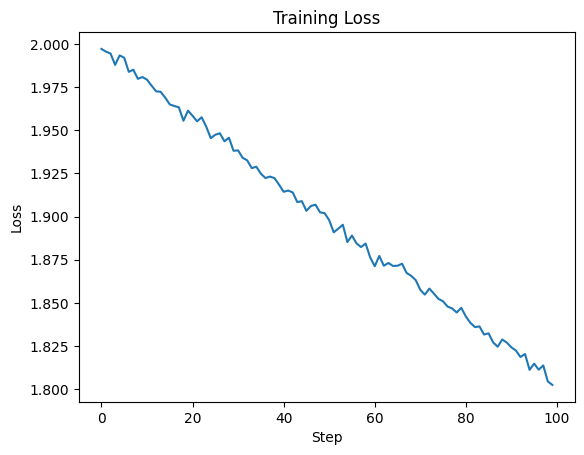

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the Selective State Space Layer
class SelectiveStateSpaceLayer(nn.Module):
    def __init__(self, d_model, d_state, d_conv):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv

        # State space parameters
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Parameter(torch.randn(d_model, d_state))
        self.C = nn.Parameter(torch.randn(d_model, d_state))

        # Convolution for selective mechanism
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=d_conv, padding=d_conv//2)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        batch_size, seq_len, _ = x.shape

        # Apply convolution for selectivity
        x_conv = self.conv(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, seq_len, d_model)

        # State space computation
        h = torch.zeros(batch_size, self.d_state, device=x.device)  # Initial state (batch_size, d_state)
        outputs = []
        for t in range(seq_len):
            # Update hidden state: h = tanh(A @ h + B @ x_conv[:, t, :])
            h = torch.tanh(
                h @ self.A.T + x_conv[:, t, :] @ self.B  # (batch_size, d_state)
            )
            # Compute output: y_t = C @ h
            y_t = h @ self.C.T  # (batch_size, d_model)
            outputs.append(y_t)
        outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_len, d_model)

        return outputs

# Define the Mamba Block
class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv):
        super().__init__()
        self.ssm = SelectiveStateSpaceLayer(d_model, d_state, d_conv)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # Residual connection
        return self.norm(x + self.ssm(x))

# Define the Mamba Model
class Mamba(nn.Module):
    def __init__(self, n_layers, d_model, d_state, d_conv):
        super().__init__()
        self.layers = nn.ModuleList([MambaBlock(d_model, d_state, d_conv) for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
batch_size = 32
seq_len = 100
d_model = 128
d_state = 64
d_conv = 3
n_layers = 4

# Create a random input sequence
x = torch.randn(batch_size, seq_len, d_model)

# Initialize the Mamba model
model = Mamba(n_layers, d_model, d_state, d_conv)

# Forward pass
output = model(x)
print("Output shape:", output.shape)  # Should be (batch_size, seq_len, d_model)

# Training Loop (Example)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Dummy target (for demonstration)
target = torch.randn(batch_size, seq_len, d_model)

# Training for a few steps
losses = []
for step in range(100):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

# Plot the training loss
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Knowledge Distillation Loss: 28.972108840942383
Step 0, Loss: 28.313682556152344
Step 10, Loss: 24.861820220947266
Step 20, Loss: 22.82591438293457
Step 30, Loss: 21.13522720336914
Step 40, Loss: 19.675195693969727
Step 50, Loss: 18.368146896362305
Step 60, Loss: 17.16640853881836
Step 70, Loss: 16.06174087524414
Step 80, Loss: 15.073546409606934
Step 90, Loss: 14.14865779876709


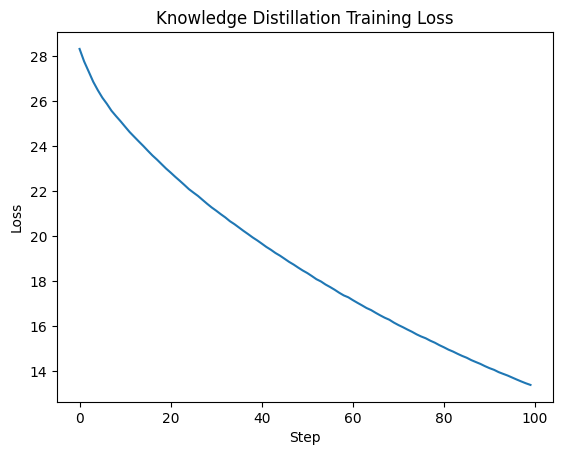

In [ ]:
# Install required libraries
# !pip install transformers

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load a pre-trained GPT-2 model as the teacher
teacher_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define a smaller student model (e.g., a smaller GPT-2 or custom architecture)
class StudentModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model, nhead=8) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        for layer in self.layers:
            x = layer(x)
        return self.fc(x)

# Hyperparameters
vocab_size = tokenizer.vocab_size
d_model = 256  # Smaller hidden size for the student
n_layers = 4   # Fewer layers for the student
temperature = 2.0  # Temperature for softening logits
alpha = 0.5  # Weight for KD loss (balance between KD loss and cross-entropy loss)
batch_size = 2
seq_len = 32

# Initialize student model
student_model = StudentModel(vocab_size, d_model, n_layers)

# Example input
input_text = "Knowledge distillation is a powerful technique"
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Forward pass through teacher and student models
teacher_logits = teacher_model(input_ids).logits
student_logits = student_model(input_ids)

# Loss function for Knowledge Distillation
def kd_loss(student_logits, teacher_logits, temperature, alpha):
    # Soften the teacher's logits with temperature
    soft_teacher = F.softmax(teacher_logits / temperature, dim=-1)
    # Compute the student's log-softmax output
    soft_student = F.log_softmax(student_logits / temperature, dim=-1)
    # Compute the KL divergence loss
    kd_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (temperature ** 2)
    # Compute the standard cross-entropy loss
    ce_loss = F.cross_entropy(student_logits.view(-1, vocab_size), input_ids.view(-1))
    # Combine the losses
    return alpha * kd_loss + (1 - alpha) * ce_loss

# Compute loss
loss = kd_loss(student_logits, teacher_logits, temperature, alpha)
print("Knowledge Distillation Loss:", loss.item())

# Training Loop (Example)
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
losses = []

# Dummy dataset (for demonstration)
dataset = [
    "Knowledge distillation is a powerful technique",
    "Large language models are computationally expensive",
    "Compressing models improves efficiency",
    "The student model learns from the teacher model"
]

# Tokenize the dataset and pad sequences to the same length
input_ids = [tokenizer.encode(text, return_tensors="pt") for text in dataset]
max_length = max([ids.size(1) for ids in input_ids])  # Find the longest sequence
input_ids = [F.pad(ids, (0, max_length - ids.size(1)), value=tokenizer.pad_token_id) for ids in input_ids]  # Pad sequences
input_ids = torch.cat(input_ids, dim=0)  # Combine into a single tensor

# Training loop
for step in range(100):  # Train for 100 steps
    optimizer.zero_grad()

    # Forward pass
    teacher_logits = teacher_model(input_ids).logits
    student_logits = student_model(input_ids)

    # Compute loss
    loss = kd_loss(student_logits, teacher_logits, temperature, alpha)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store loss for plotting
    losses.append(loss.item())

    # Print loss every 10 steps
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

# Plot the training loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Knowledge Distillation Training Loss")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_model, d_latent, n_heads):
        super().__init__()
        self.d_model = d_model
        self.d_latent = d_latent
        self.n_heads = n_heads
        self.head_dim = d_latent // n_heads

        # Projection to latent space
        self.projection = nn.Linear(d_model, d_latent)

        # Multi-head attention layers
        self.W_Q = nn.Linear(d_latent, d_latent)
        self.W_K = nn.Linear(d_latent, d_latent)
        self.W_V = nn.Linear(d_latent, d_latent)
        self.W_O = nn.Linear(d_latent, d_model)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        batch_size, seq_len, _ = x.shape

        # Project input to latent space
        z = self.projection(x)  # (batch_size, seq_len, d_latent)

        # Compute queries, keys, and values
        Q = self.W_Q(z)  # (batch_size, seq_len, d_latent)
        K = self.W_K(z)  # (batch_size, seq_len, d_latent)
        V = self.W_V(z)  # (batch_size, seq_len, d_latent)

        # Split into multiple heads
        Q = Q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)
        V = V.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)

        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, n_heads, seq_len, seq_len)
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)  # (batch_size, n_heads, seq_len, head_dim)

        # Concatenate heads and project back to original dimension
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_latent)  # (batch_size, seq_len, d_latent)
        output = self.W_O(attn_output)  # (batch_size, seq_len, d_model)

        return output

# Example usage
d_model = 512
d_latent = 256
n_heads = 8
batch_size = 2
seq_len = 32

# Input tensor
x = torch.randn(batch_size, seq_len, d_model)

# Initialize MLA
mla = MultiHeadLatentAttention(d_model, d_latent, n_heads)

# Forward pass
output = mla(x)
print("Output shape:", output.shape)  # Should be (batch_size, seq_len, d_model)

Output shape: torch.Size([2, 32, 512])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

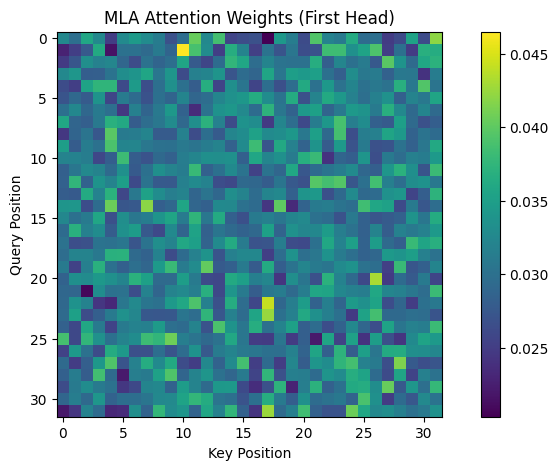

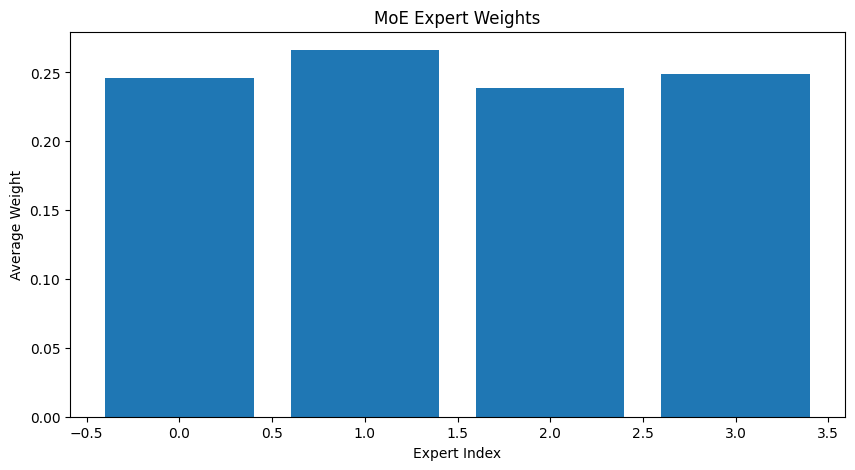

In [ ]:
# Install required libraries
!pip install torch matplotlib

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define Multi-head Latent Attention (MLA)
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_model, d_latent, n_heads):
        super().__init__()
        self.d_model = d_model
        self.d_latent = d_latent
        self.n_heads = n_heads
        self.head_dim = d_latent // n_heads

        # Projection to latent space
        self.projection = nn.Linear(d_model, d_latent)

        # Multi-head attention layers
        self.W_Q = nn.Linear(d_latent, d_latent)
        self.W_K = nn.Linear(d_latent, d_latent)
        self.W_V = nn.Linear(d_latent, d_latent)
        self.W_O = nn.Linear(d_latent, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        z = self.projection(x)  # Project to latent space
        Q, K, V = self.W_Q(z), self.W_K(z), self.W_V(z)  # Compute Q, K, V
        Q = Q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_latent)
        output = self.W_O(attn_output)
        return output, attn_weights

# Define DeepSeekMoE
class DeepSeekMoE(nn.Module):
    def __init__(self, d_model, n_experts, expert_capacity):
        super().__init__()
        self.d_model = d_model
        self.n_experts = n_experts
        self.expert_capacity = expert_capacity
        self.experts = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        gate_scores = self.gate(x)  # Compute gate scores
        expert_weights = F.softmax(gate_scores, dim=-1)  # Softmax over experts
        outputs = torch.zeros_like(x)
        for i in range(self.n_experts):
            expert_mask = (expert_weights.argmax(dim=-1) == i)  # Select inputs for expert i
            if expert_mask.sum() > 0:
                expert_input = x[expert_mask]
                expert_output = self.experts[i](expert_input)
                outputs[expert_mask] = expert_output
        return outputs, expert_weights

# Define Multi-Token Prediction Training
class MultiTokenPrediction(nn.Module):
    def __init__(self, d_model, vocab_size, n_tokens):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.n_tokens = n_tokens
        self.lm_head = nn.Linear(d_model, vocab_size * n_tokens)

    def forward(self, x):
        logits = self.lm_head(x)  # Predict multiple tokens
        logits = logits.view(x.size(0), x.size(1), self.n_tokens, self.vocab_size)
        return logits

# Hyperparameters
d_model = 512
d_latent = 256
n_heads = 8
n_experts = 4
expert_capacity = 32
vocab_size = 10000
n_tokens = 3
batch_size = 2
seq_len = 32

# Initialize components
mla = MultiHeadLatentAttention(d_model, d_latent, n_heads)
moe = DeepSeekMoE(d_model, n_experts, expert_capacity)
mtp = MultiTokenPrediction(d_model, vocab_size, n_tokens)

# Example input
x = torch.randn(batch_size, seq_len, d_model)

# Forward pass through MLA
mla_output, mla_attn_weights = mla(x)
print("MLA Output Shape:", mla_output.shape)  # Should be (batch_size, seq_len, d_model)

# Forward pass through DeepSeekMoE
moe_output, moe_expert_weights = moe(mla_output)
print("MoE Output Shape:", moe_output.shape)  # Should be (batch_size, seq_len, d_model)

# Forward pass through Multi-Token Prediction
mtp_logits = mtp(moe_output)
print("Multi-Token Logits Shape:", mtp_logits.shape)  # Should be (batch_size, seq_len, n_tokens, vocab_size)

# Visualization of Attention Weights
plt.figure(figsize=(10, 5))
plt.imshow(mla_attn_weights[0, 0].detach().numpy(), cmap='viridis')  # Visualize first head's attention weights
plt.colorbar()
plt.title("MLA Attention Weights (First Head)")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

# Visualization of Expert Weights
plt.figure(figsize=(10, 5))
plt.bar(range(n_experts), moe_expert_weights[0].mean(dim=0).detach().numpy())  # Average expert weights for first sequence
plt.title("MoE Expert Weights")
plt.xlabel("Expert Index")
plt.ylabel("Average Weight")
plt.show()